In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.regularizers import l2
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check if the GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:45<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# Paths for train, test, and val directories
path = path + '/chest_xray'
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")
val_dir = os.path.join(path, "val")

train_dir, test_dir, val_dir

('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train',
 '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test',
 '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')

In [ ]:
def concat_data(data_path):
  filepaths = []
  labels = []

  folds = os.listdir(data_path)
  for file in folds:
      foldpath = os.path.join(data_path, file)
      filelist = os.listdir(foldpath)

      for f in filelist:
          fpath = os.path.join(foldpath, f)
          filepaths.append(fpath)
          labels.append(file)

  FSeries = pd.Series(filepaths, name='filepaths')
  LSeries = pd.Series(labels, name='label')

  df = pd.concat([FSeries, LSeries], axis=1)
  return df

train_df = concat_data(train_dir)
test_df = concat_data(test_dir)
valid_df = concat_data(val_dir)

In [ ]:
# Combine all data
all_data_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
print(all_data_df['label'].value_counts())

all_data_df

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64


,filepaths,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
1,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
2,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
3,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
4,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
...,...,...
5851,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
5852,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
5853,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
5854,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL


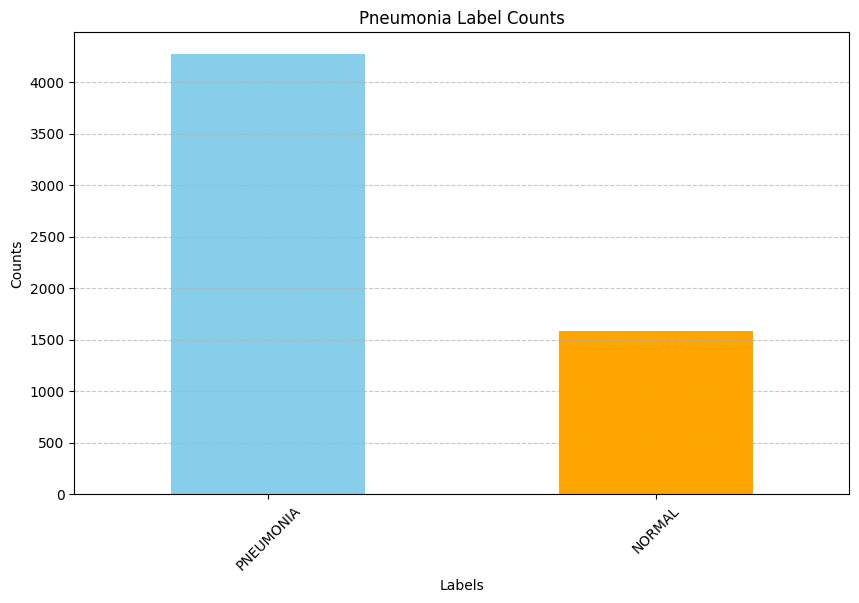

In [ ]:
import matplotlib.pyplot as plt

label_counts = all_data_df['label'].value_counts()

colors = ['skyblue', 'orange']
bar_colors = [colors[i % 2] for i in range(len(label_counts))]

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=bar_colors)
plt.title('Pneumonia Label Counts')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# load augmented data for NORMAL class
# Set up directories
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

normal_aug_df = concat_data('/content/drive/MyDrive/augmented_normal_images_2/')
normal_aug_df

Mounted at /content/drive


,filepaths,label
0,/content/drive/MyDrive/augmented_normal_images...,NORMAL
1,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2,/content/drive/MyDrive/augmented_normal_images...,NORMAL
3,/content/drive/MyDrive/augmented_normal_images...,NORMAL
4,/content/drive/MyDrive/augmented_normal_images...,NORMAL
...,...,...
2685,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2686,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2687,/content/drive/MyDrive/augmented_normal_images...,NORMAL
2688,/content/drive/MyDrive/augmented_normal_images...,NORMAL


In [ ]:
# Combine all data
all_data_df = pd.concat([train_df, test_df, valid_df, normal_aug_df], ignore_index=True)
print(all_data_df['label'].value_counts())

all_data_df

label
PNEUMONIA    4273
NORMAL       4273
Name: count, dtype: int64


,filepaths,label
0,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
1,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
2,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
3,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
4,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
...,...,...
8541,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8542,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8543,/content/drive/MyDrive/augmented_normal_images...,NORMAL
8544,/content/drive/MyDrive/augmented_normal_images...,NORMAL


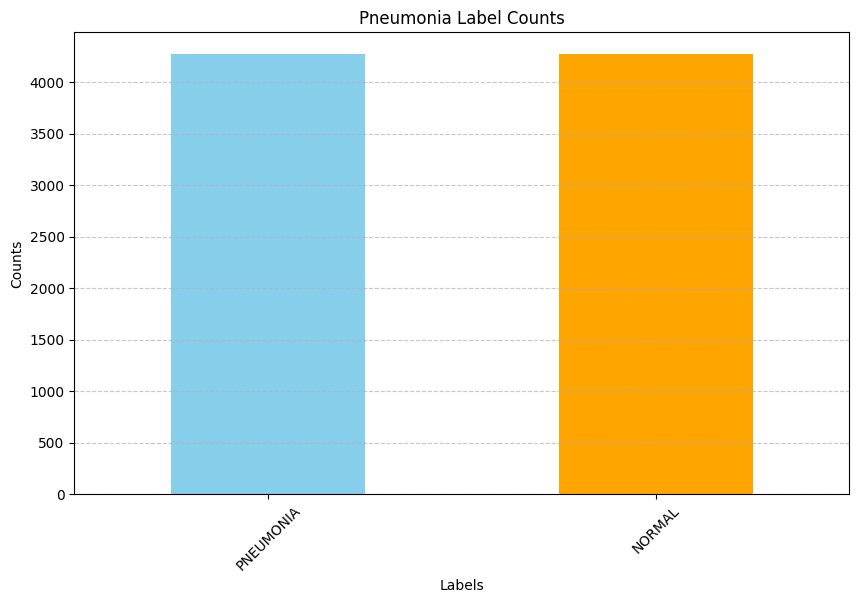

In [ ]:
label_counts = all_data_df['label'].value_counts()

colors = ['skyblue', 'orange']
bar_colors = [colors[i % 2] for i in range(len(label_counts))]

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=bar_colors)
plt.title('Pneumonia Label Counts')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Split into training (70%) and remaining (30%) for validation and test
train_df, remaining_df = train_test_split(all_data_df, test_size=0.3, stratify=all_data_df['label'], random_state=42)

# Split remaining data into validation (50% of remaining) and test (50% of remaining)
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['label'], random_state=42)

print(f"Train label distribution:\n{train_df['label'].value_counts()}")
print(f"Validation label distribution:\n{valid_df['label'].value_counts()}")
print(f"Test label distribution:\n{test_df['label'].value_counts()}")

Train label distribution:
label
NORMAL       2991
PNEUMONIA    2991
Name: count, dtype: int64
Validation label distribution:
label
NORMAL       641
PNEUMONIA    641
Name: count, dtype: int64
Test label distribution:
label
PNEUMONIA    641
NORMAL       641
Name: count, dtype: int64


In [ ]:
batch_size = 16
img_size = (224, 224)

data_gen = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

val_generator = data_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = data_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5982 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.


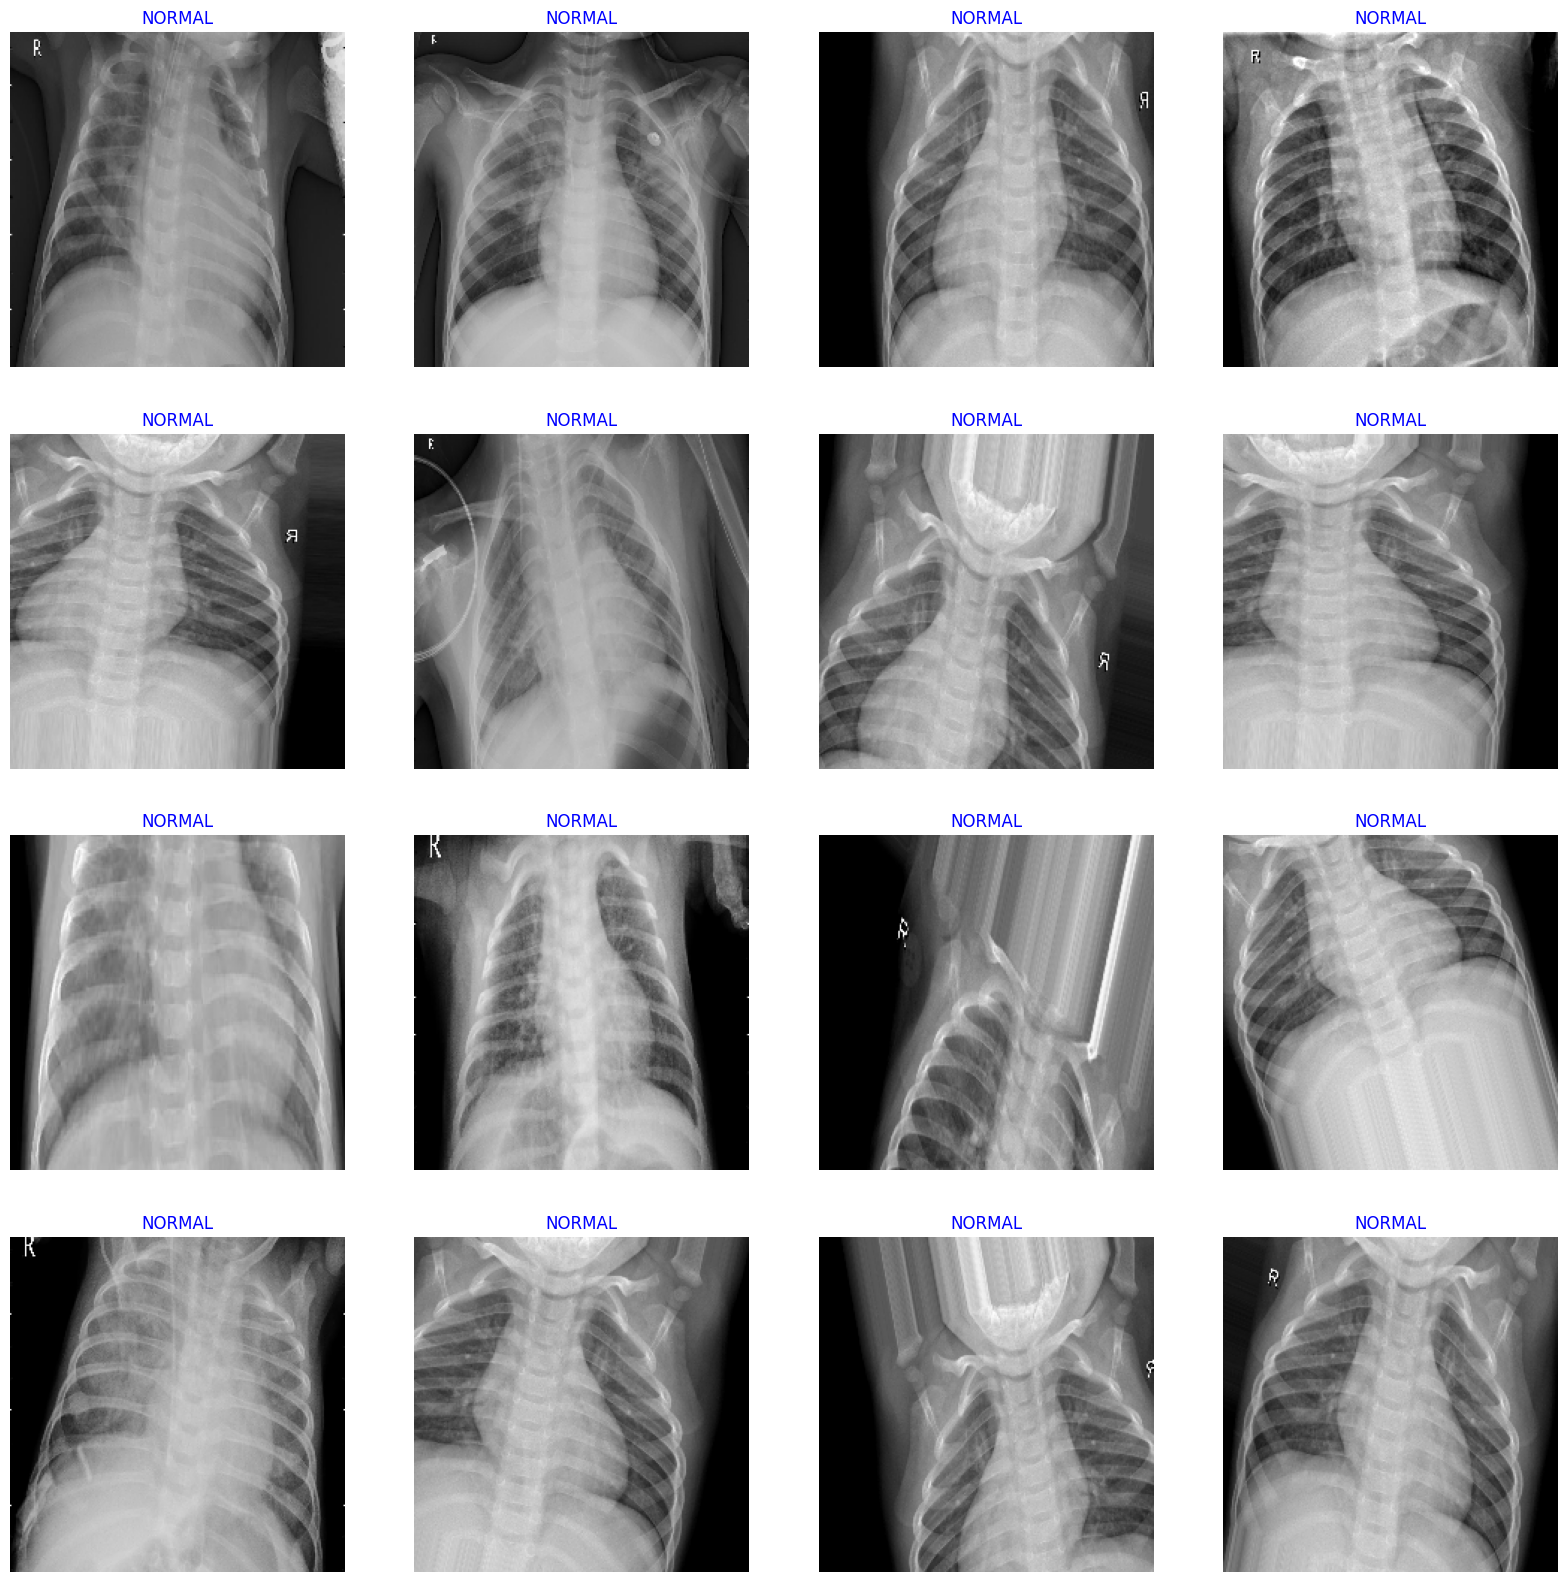

In [ ]:
gen_dict = test_generator.class_indices
classes = list(gen_dict.keys())
images , labels = next(test_generator)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

def vgg16(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = vgg16(input_shape=(224, 224, 3))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from datetime import datetime

print('start', datetime.now())
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=5)
print('end', datetime.now())

start 2024-12-18 11:55:56.683800
Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.8713 - loss: 0.6062 - val_accuracy: 0.9649 - val_loss: 0.0982
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 86s 228ms/step - accuracy: 0.9654 - loss: 0.0955 - val_accuracy: 0.9797 - val_loss: 0.0569
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 78s 206ms/step - accuracy: 0.9648 - loss: 0.0839 - val_accuracy: 0.9789 - val_loss: 0.0655
Epoch 4/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 199ms/step - accuracy: 0.9736 - loss: 0.0625 - val_accuracy: 0.9805 - val_loss: 0.0618
Epoch 5/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 91s 223ms/step - accuracy: 0.9742 - loss: 0.0669 - val_accuracy: 0.9641 - val_loss: 0.0998
end 2024-12-18 12:09:42.226073


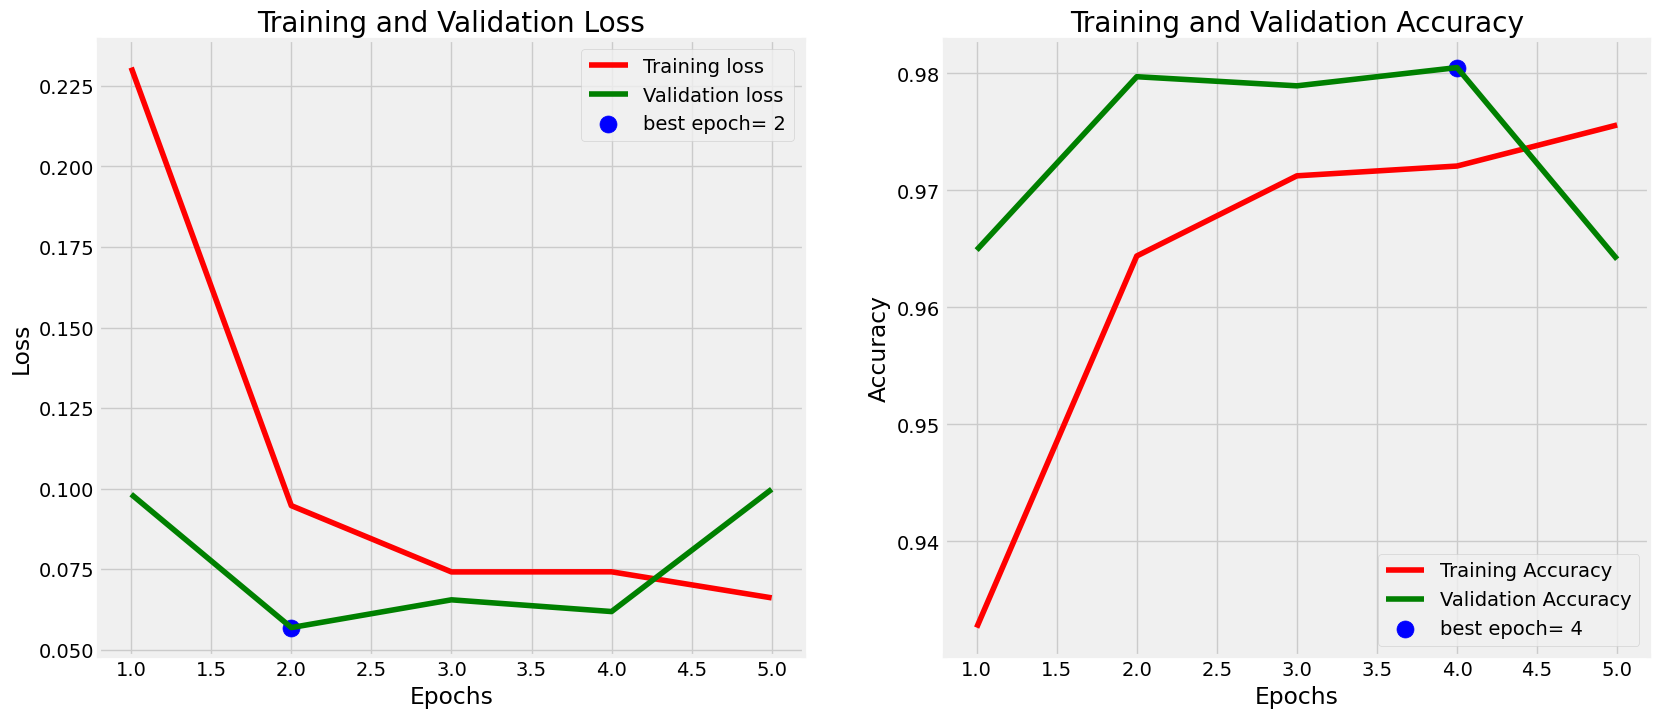

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps = len(test_generator))
print("The testing accuracy is: ", test_accuracy * 100, "%")

81/81 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9663 - loss: 0.0977
The testing accuracy is:  96.09984159469604 %


In [ ]:
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_generator.classes, y_pred)
cm

81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step


array([[595,  46],
       [  4, 637]])

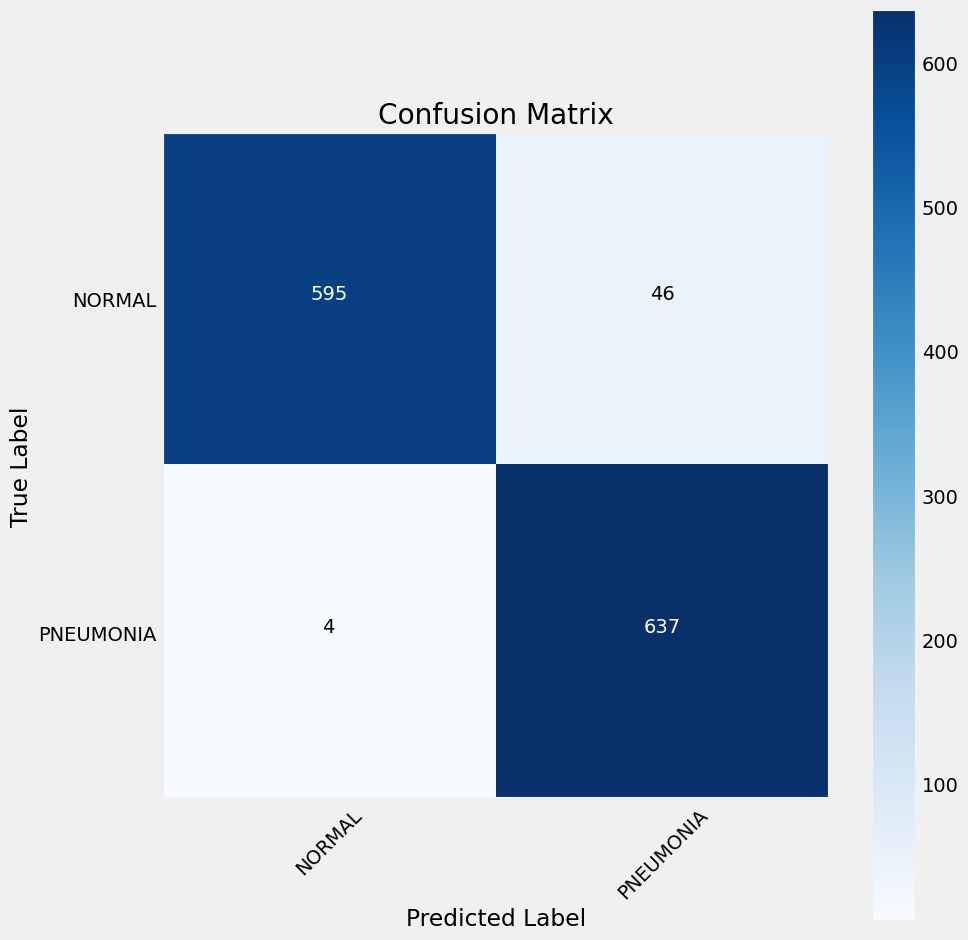

In [ ]:
import itertools

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.grid(False)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(test_generator.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.99      0.93      0.96       641
   PNEUMONIA       0.93      0.99      0.96       641

    accuracy                           0.96      1282
   macro avg       0.96      0.96      0.96      1282
weighted avg       0.96      0.96      0.96      1282



In [ ]:
model.save('/content/drive/MyDrive/modelsaved/vgg16_model.h5')
